In [1]:
# define libraries to use
import numpy as np
import pandas as pd

#from pathlib import Path
import requests,json
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
#import scipy as sp
#%matplotlib inline

pd.options.display.max_columns = None

In [2]:
def GoodVPICDecode(picDecodeResult):
	return (picDecodeResult in {'0','0,10','1,10','1,400','1,10,400'})

In [3]:
nydmvVinColumns = [ 
    'entry', 'ORIG_VIN', 'ABS', 'AdaptiveCruiseControl', 'AdaptiveDrivingBeam', 'AdaptiveHeadlights', 'AutoReverseSystem', 
    'AutomaticPedestrianAlertingSound', 'BlindSpotIntervention', 'BlindSpotMon', 'BodyClass', 'CIB', 'CurbWeightLB', 
    'DaytimeRunningLight', 'Doors', 'DriverAssist', 'DynamicBrakeSupport', 'EDR', 'ESC', 'ErrorCode', 'ForwardCollisionWarning', 
    'GCWR', 'GCWR_to', 'GVWR', 'GVWR_to', 'LaneCenteringAssistance', 'LaneDepartureWarning', 'LaneKeepSystem', 'LowerBeamHeadlampLightSource', 
    'Make', 'MakeID', 'Manufacturer', 'ManufacturerId', 'Model', 'ModelID', 'ModelYear', 'NCSABodyType', 'NCSAMake', 'NCSAModel', 'ParkAssist', 
    'PedestrianAutomaticEmergencyBraking', 'RearAutomaticEmergencyBraking', 'RearCrossTrafficAlert', 'Seats', 'SemiautomaticHeadlampBeamSwitching', 'Series',
    'Series2', 'SuggestedVIN', 'TPMS', 'TractionControl', 'Trim', 'Trim2', 'VIN', 'VehicleType', 
]

nydmvVinStyCols = [ 
    'ABS', 'AdaptiveCruiseControl', 'AdaptiveDrivingBeam',  'AutomaticPedestrianAlertingSound', 'BlindSpotIntervention', 'BlindSpotMon', 'CIB', 
    'DaytimeRunningLight', 'DynamicBrakeSupport', 'ESC', 'ForwardCollisionWarning', 
    'LaneCenteringAssistance', 'LaneDepartureWarning', 'LaneKeepSystem', 'LowerBeamHeadlampLightSource', 
    'ParkAssist', 
    'PedestrianAutomaticEmergencyBraking', 'RearAutomaticEmergencyBraking', 'RearCrossTrafficAlert', 'SemiautomaticHeadlampBeamSwitching', 
    'TPMS', 'TractionControl', 
]

#nydmvVinDecodeDf = pd.read_csv("tmp/nydmvvin-goodhdr/NYDMV-VIN-OUTPUT-merged-fixedquotes-cols.csv",low_memory=False)
nydmvVinDecodeDf = pd.read_pickle("tmp/nydmvvin-goodhdr/NYDMV-VIN-OUTPUT-merged-fixedquotes-cols.pkl")


In [4]:
nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350715 entries, 0 to 11351614
Data columns (total 56 columns):
 #   Column                               Non-Null Count     Dtype  
---  ------                               --------------     -----  
 0   entry                                11350715 non-null  int64  
 1   ORIG_VIN                             11350709 non-null  object 
 2   ABS                                  4021067 non-null   object 
 3   AdaptiveCruiseControl                2516625 non-null   object 
 4   AdaptiveDrivingBeam                  1729409 non-null   object 
 5   AdaptiveHeadlights                   0 non-null         float64
 6   AutoReverseSystem                    3976894 non-null   object 
 7   AutomaticPedestrianAlertingSound     714624 non-null    object 
 8   BlindSpotIntervention                119627 non-null    object 
 9   BlindSpotMon                         2889679 non-null   object 
 10  BodyClass                            11132344 non-nu

In [9]:
# Fix ModelID type and store Models dict for later use
nydmvVinDecodeDf["ModelID"] = nydmvVinDecodeDf["ModelID"].astype("float64")
nydmvModelIDCat = dict(np.array(nydmvVinDecodeDf[["ModelID","Model"]].drop_duplicates()))
print("Number of Models found",len(nydmvModelIDCat))

import pickle

f = open("tmp/nydmv-vindecode-modelid-dict.pkl","wb")
pickle.dump(nydmvModelIDCat,f)
f.close()

Number of Models found 6429


In [10]:
nydmvVinDecodeDf["AdaptiveCruiseControl"].value_counts().sort_values(ascending=False)

Standard          1372225
Optional           686530
Not Applicable     439828
Not Available       18042
Name: AdaptiveCruiseControl, dtype: int64

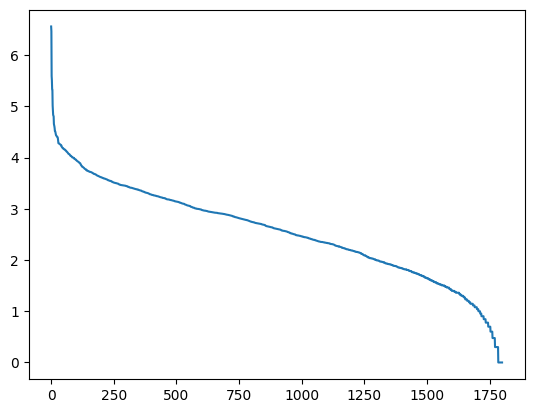

In [11]:
ccc = nydmvVinDecodeDf.value_counts(subset=nydmvVinStyCols,dropna=False).sort_values(ascending=False)
x = ccc.values
plt.plot(np.log10(x))
#plt.hist(x,log=True)

In [12]:
for col in nydmvVinStyCols:
    print(col.ljust(max([len(x) for x in nydmvVinStyCols])+4),list(nydmvVinDecodeDf[col].unique()))

ABS                                     [nan, 'Not Applicable', 'Standard', 'Not Available', 'Optional']
AdaptiveCruiseControl                   [nan, 'Not Applicable', 'Standard', 'Optional', 'Not Available']
AdaptiveDrivingBeam                     [nan, 'Not Applicable', 'Standard', 'Optional', 'Not Available']
AutomaticPedestrianAlertingSound        [nan, 'Not Applicable', 'Standard', 'Not Available', 'Optional']
BlindSpotIntervention                   [nan, 'Standard', 'Optional']
BlindSpotMon                            [nan, 'Not Applicable', 'Standard', 'Optional', 'Not Available']
CIB                                     [nan, 'Not Applicable', 'Standard', 'Not Available', 'Optional']
DaytimeRunningLight                     [nan, 'Not Applicable', 'Standard', 'Optional', 'Not Available']
DynamicBrakeSupport                     [nan, 'Not Applicable', 'Standard', 'Not Available', 'Optional']
ESC                                     [nan, 'Not Applicable', 'Standard']
ForwardCollisi

From DataAnalysis-fars
```
AdaptiveCruiseControlId              {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
AdaptiveDrivingBeamId                {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
AntilockBrakeSystemId                {nan: nan, 1.0: 'Standard', 3.0: 'Optional', 2.0: 'Not Available'}
AutoPedestrianAlertingSoundId        {nan: nan, 0.0: 'Not Applicable', 2.0: 'Not Available', 1.0: 'Standard', 3.0: 'Optional'}
BackupCameraId                       {nan: nan, 1.0: 'Standard', 3.0: 'Optional', 0.0: 'Not Applicable', 2.0: 'Not Available'}
BlindSpotInterventionId              {nan: nan}
BlindSpotWarningId                   {nan: nan, 1.0: 'Standard', 3.0: 'Optional', 0.0: 'Not Applicable', 2.0: 'Not Available'}
CrashImminentBrakingID               {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
DaytimeRunningLightId                {nan: nan, 3.0: 'Optional', 1.0: 'Standard', 0.0: 'Not Applicable', 2.0: 'Not Available'}
DynamicBrakeSupportId                {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
ElectronicStabilityControlId         {nan: nan, 1.0: 'Standard'}
ForwardCollisionWarningId            {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
LaneCenteringAssistanceId            {nan: nan, 1.0: 'Standard', 3.0: 'Optional'}
LaneDepartureWarningId               {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
LaneKeepingAssistanceId              {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 4.0: 'Not Available', 5.0: 'Optional'}
ParkAssistId                         {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 2.0: 'Not Available', 3.0: 'Optional'}
PedestrianAutoEmergencyBrakingId     {nan: nan, 0.0: 'Not Applicable', 1.0: 'Standard', 3.0: 'Optional', 2.0: 'Not Available'}
RearAutomaticEmergencyBrakingId      {nan: nan}
RearCrossTrafficAlertId              {nan: nan, 0.0: 'Not Applicable', 1.0: 'Standard', 2.0: 'Optional', 3.0: 'Not Available'}
SemiAutoHeadlampBeamSwitchingId      {nan: nan, 1.0: 'Standard', 0.0: 'Not Applicable', 3.0: 'Optional', 2.0: 'Not Available'}
TPMSId                               {nan: nan, 1.0: 'Direct', 2.0: 'Indirect', 0.0: 'Not Applicable'}
TractionControlId                    {nan: nan, 1.0: 'Standard', 3.0: 'Optional'}
```

In [13]:
safetyCatMost     = {np.nan: np.nan, 'Not Applicable' : 0, 'Standard' : 1 , 'Not Available' : 2 , 'Optional' : 3  }
safetyCatLKA      = {np.nan: np.nan, 'Not Applicable' : 0, 'Standard' : 1 , 'Not Available' : 4 , 'Optional' : 5  } 
safetyCatTPMS     = {np.nan: np.nan, 'Not Applicable' : 0, 'Direct'   : 1 , 'Indirect'      : 2 } 
safetyCatHdLmpSrc = {np.nan: np.nan, 'Not Applicable' : 0, 'Halogen'  : 1 , 'HID'           : 2 , 'LED'     : 3 , 
                                     'Other' : 4, 'Halogen, HID' : 5, 'Halogen, LED' : 6, 'Halogen, Other' : 7, 
                                     'HID, LED' : 8, 'HID, Other' : 9, 'LED, Other' : 10, 'Halogen, HID, LED' : 11,
                                     'Halogen, HID, Other' : 12, 'Halogen, LED, Other' : 13, 'HID, LED, Other' : 14, 
                                     'Halogen, HID, LED, Other' : 15, 'Laser' : 16,}

safetyColMap = {
    'ABS' : 'AntilockBrakeSystemId',
    'AdaptiveCruiseControl' : 'AdaptiveCruiseControlId',
    'AdaptiveDrivingBeam' : 'AdaptiveDrivingBeamId',
    'AutomaticPedestrianAlertingSound' : 'AutoPedestrianAlertingSoundId',
    'BlindSpotIntervention' : 'BlindSpotInterventionId',
    'BlindSpotMon' : 'BlindSpotWarningId',
    'CIB' : 'CrashImminentBrakingID',
    'DaytimeRunningLight' : 'DaytimeRunningLightId',
    'DynamicBrakeSupport' : 'DynamicBrakeSupportId',
    'ESC' : 'ElectronicStabilityControlId',
    'ForwardCollisionWarning' : 'ForwardCollisionWarningId',
    'LaneCenteringAssistance' : 'LaneCenteringAssistanceId',
    'LaneDepartureWarning' : 'LaneDepartureWarningId',
    'LaneKeepSystem' : 'LaneKeepingAssistanceId',
    'LowerBeamHeadlampLightSource' : 'HeadlampLightSourceId',
    'ParkAssist' : 'ParkAssistId',
    'PedestrianAutomaticEmergencyBraking' : 'PedestrianAutoEmergencyBrakingId',
    'RearAutomaticEmergencyBraking' : 'RearAutomaticEmergencyBrakingId',
    'RearCrossTrafficAlert' : 'RearCrossTrafficAlertId',
    'SemiautomaticHeadlampBeamSwitching' : 'SemiAutoHeadlampBeamSwitchingId',
    'TPMS' : 'TPMSId',
    'TractionControl' : 'TractionControlId',
}

for col in safetyColMap.keys():
    newCol = safetyColMap[col]
    print(newCol,":",col,end="")
    if col == 'TPMS':
        nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf.apply(lambda row: safetyCatTPMS[row[col]] if isinstance(row[col],str) else np.nan,axis=1)
    elif col == 'LaneKeepSystem':
        nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf.apply(lambda row: safetyCatLKA[row[col]] if isinstance(row[col],str) else np.nan,axis=1)
    elif col == 'LowerBeamHeadlampLightSource':
        nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf.apply(lambda row: safetyCatHdLmpSrc[row[col]] if isinstance(row[col],str) else np.nan,axis=1)
    else:
        nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf.apply(lambda row: safetyCatMost[row[col]] if isinstance(row[col],str) else np.nan,axis=1)
        # np.int64(row["GrossVehicleWeightRatingFromId"]) if ~np.isnan(row["GrossVehicleWeightRatingFromId"]) else np.nan
    nydmvVinDecodeDf.drop(columns=col,inplace=True)
    print("\r"," "*80,end="\r")
print()

for col in safetyColMap.values():
    print(col.ljust(max([len(x) for x in safetyColMap.values()])+4),list(nydmvVinDecodeDf[col].unique()))

## idenfity columns with valid decodes (GoodVPICDecode written into input file)
##nydmvVinDecodeDf["GoodVPICDecode"] = nydmvVinDecodeDf.apply(lambda row: GoodVPICDecode(row["ErrorCode"]),axis=1)

# drop unneccesary columns
#  AutoReverseSystem -> An auto-reverse system enables power windows and sunroofs on motor vehicles to automatically reverse direction when such power windows and panels detect an obstruction
#  GCWR, GCWR_to     -> all null values, Gross Combination Weight Rating (From and To); Gross combination weight rating (GCWR) is the maximum allowable combined mass of a road vehicle, 
#                       the passengers and cargo in the tow vehicle, plus the mass of the trailer and cargo in the trailer. 
#  Make              -> Keep MakeID
#  Model             -> Keep ModelID
#  Manufacturer, ManufacturerId -> Make will be used instead
#  NCSABodyType, NCSAMake, NCSAModel -> all null
#  EDR               -> Event Data Recorder, not a preventitive feature


nydmvVinDecodeDf.drop(columns=["AutoReverseSystem","GCWR","GCWR_to","Make","Model","Manufacturer","ManufacturerId","NCSABodyType", "NCSAMake", "NCSAModel", "EDR", "AdaptiveHeadlights","DriverAssist", "CurbWeightLB"],inplace=True)

catDic = {}

# additional categories to correct
catDic["VehicleType"] = {
    np.nan: np.nan,
    'BUS': 5 ,
    'INCOMPLETE VEHICLE': 10 ,
    'LOW SPEED VEHICLE (LSV)': 9 ,
    'MOTORCYCLE': 1 ,
    'MULTIPURPOSE PASSENGER VEHICLE (MPV)': 7 ,
    'OFF ROAD VEHICLE': 13 ,
    'PASSENGER CAR': 2 ,
    'TRAILER': 6 ,
    'TRUCK': 3
}

catDic["GVWR"] = {
    np.nan: np.nan,
    'Class 1: 6,000 lb or less (2,722 kg or less)': 1 ,
    'Class 1A: 3,000 lb or less (1,360 kg or less)': 10 ,
    'Class 1B: 3,001 - 4,000 lb (1,360 - 1,814 kg)': 11 ,
    'Class 1C: 4,001 - 5,000 lb (1,814 - 2,268 kg)': 12 ,
    'Class 1D: 5,001 - 6,000 lb (2,268 - 2,722 kg)': 13 ,
    'Class 2: 6,001 - 10,000 lb (2,722 - 4,536 kg)': 2 ,
    'Class 2E: 6,001 - 7,000 lb (2,722 - 3,175 kg)': 14 ,
    'Class 2F: 7,001 - 8,000 lb (3,175 - 3,629 kg)': 15 ,
    'Class 2G: 8,001 - 9,000 lb (3,629 - 4,082 kg)': 16 ,
    'Class 2H: 9,001 - 10,000 lb (4,082 - 4,536 kg)': 17 ,
    'Class 3: 10,001 - 14,000 lb (4,536 - 6,350 kg)': 4 ,
    'Class 4: 14,001 - 16,000 lb (6,350 - 7,258 kg)': 5 ,
    'Class 5: 16,001 - 19,500 lb (7,258 - 8,845 kg)': 6 ,
    'Class 6: 19,501 - 26,000 lb (8,845 - 11,794 kg)': 7 ,
    'Class 7: 26,001 - 33,000 lb (11,794 - 14,969 kg)': 8 ,
    'Class 8: 33,001 lb and above (14,969 kg and above)': 9 ,
}

catDic["GVWR_to"] = catDic["GVWR"]

catDic["BodyClass"] = {
    np.nan: np.nan,
    'Convertible/Cabriolet': 1 ,
    'Minivan': 2 ,
    'Coupe': 3 ,
    'Low Speed Vehicle (LSV) / Neighborhood Electric Vehicle (NEV)': 4 ,
    'Hatchback/Liftback/Notchback': 5 ,
    'Motorcycle - Standard': 6 ,
    'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)': 7 ,
    'Crossover Utility Vehicle (CUV)': 8 ,
    'Van': 9 ,
    'Roadster': 10 ,
    'Truck': 11 ,
    'Motorcycle - Scooter': 12 ,
    'Sedan/Saloon': 13 ,
    'Wagon': 15 ,
    'Bus': 16 ,
    'Pickup': 60 ,
    'Trailer': 61 ,
    'Incomplete - Cutaway': 62 ,
    'Incomplete - Chassis Cab (Single Cab)': 63 ,
    'Incomplete - Glider': 64 ,
    'Incomplete': 65 ,
    'Truck-Tractor': 66 ,
    'Incomplete - Stripped Chassis': 67 ,
    'Streetcar / Trolley': 68,
    'Off-road Vehicle - All Terrain Vehicle (ATV) (Motorcycle-style)': 69 ,
    'Incomplete - Chassis Cab (Double Cab)': 70 ,
    'Incomplete - School Bus Chassis': 71 ,
    'Incomplete - Commercial Bus Chassis': 72 ,
    'Bus - School Bus': 73 ,
    'Incomplete - Chassis Cab (Number of Cab Unknown)': 74 ,
    'Incomplete - Transit Bus Chassis': 75 ,
    'Incomplete - Motor Coach Chassis': 76 ,
    'Incomplete - Shuttle Bus Chassis': 77 ,
    'Incomplete - Motor Home Chassis': 78 ,
    'Motorcycle - Sport': 80 ,
    'Motorcycle - Touring / Sport Touring': 81 ,
    'Motorcycle - Cruiser': 82 ,
    'Motorcycle - Trike': 83 ,
    'Off-road Vehicle - Dirt Bike / Off-Road': 84 ,
    'Motorcycle - Dual Sport / Adventure / Supermoto / On/Off-road': 85 ,
    'Off-road Vehicle - Enduro (Off-road long distance racing)': 86 ,
    'Motorcycle - Small / Minibike': 87 ,
    'Off-road Vehicle - Go Kart': 88 ,
    'Motorcycle - Side Car': 90 ,
    'Motorcycle - Custom': 94 ,
    'Cargo Van': 95 ,
    'Off-road Vehicle - Snowmobile': 97 ,
    'Motorcycle - Street': 98 ,
    'Motorcycle - Enclosed Three Wheeled / Enclosed Autocycle': 100 ,
    'Motorcycle - Unenclosed Three Wheeled / Open Autocycle': 103 ,
    'Motorcycle - Moped': 104 ,
    'Off-road Vehicle - Recreational Off-Road Vehicle (ROV)': 105 ,
    'Incomplete - Bus Chassis': 107 ,
    'Motorhome': 108 ,
    'Motorcycle - Cross Country': 109,
    'Motorcycle - Underbone': 110,
    'Step Van / Walk-in Van': 111 ,
    'Incomplete - Commercial Chassis': 112 ,
    'Off-road Vehicle - Motocross (Off-road short distance, closed track racing)': 113 ,
    'Motorcycle - Competition': 114 ,
    'Incomplete - Trailer Chassis': 116,
    'Limousine': 117 ,
    'Sport Utility Truck (SUT)': 119 ,
    'Off-road Vehicle - Golf Cart': 124 ,
    'Motorcycle - Unknown Body Class': 125 ,
    'Off-road Vehicle - Farm Equipment': 126 ,
    'Off-road Vehicle - Construction Equipment': 127 ,
    'Motorized Bicycle': 996 ,
    'Other': 997 ,
    'Not Reported': 998 ,
    'Unknown': 999 ,
    # additional unknowns
    'Ambulance': 999 ,
    'Fire Apparatus': 999 ,
    'Street Sweeper': 999 , 
}

otherColMap = {
    "VehicleType"   : "VehicleTypeId",
    "GVWR"          : "GrossVehicleWeightRatingFromId",
    "GVWR_to"       : "GrossVehicleWeightRatingToId",
    "BodyClass"     : "BodyClassId",
}

for col in otherColMap.keys():
    newCol = otherColMap[col]
    print(" "*80,"\rOTHER ",newCol,":",col,end="")
    nydmvVinDecodeDf[newCol] = nydmvVinDecodeDf.apply(lambda row: catDic[col][row[col].strip() if isinstance(row[col],str) else np.nan],axis=1)
    nydmvVinDecodeDf.drop(columns=col,inplace=True)
    print(end="\r")
print()

for col in otherColMap.values():
    print(col.ljust(max([len(x) for x in safetyColMap.values()])+4),list(nydmvVinDecodeDf[col].unique()))


nydmvVinDecodeDf["MakeID"] = nydmvVinDecodeDf["MakeID"].astype("float")


                                                                                 
AntilockBrakeSystemId                [nan, 0.0, 1.0, 2.0, 3.0]
AdaptiveCruiseControlId              [nan, 0.0, 1.0, 3.0, 2.0]
AdaptiveDrivingBeamId                [nan, 0.0, 1.0, 3.0, 2.0]
AutoPedestrianAlertingSoundId        [nan, 0.0, 1.0, 2.0, 3.0]
BlindSpotInterventionId              [nan, 1.0, 3.0]
BlindSpotWarningId                   [nan, 0.0, 1.0, 3.0, 2.0]
CrashImminentBrakingID               [nan, 0.0, 1.0, 2.0, 3.0]
DaytimeRunningLightId                [nan, 0.0, 1.0, 3.0, 2.0]
DynamicBrakeSupportId                [nan, 0.0, 1.0, 2.0, 3.0]
ElectronicStabilityControlId         [nan, 0.0, 1.0]
ForwardCollisionWarningId            [nan, 0.0, 1.0, 2.0, 3.0]
LaneCenteringAssistanceId            [nan, 1.0, 3.0]
LaneDepartureWarningId               [nan, 0.0, 1.0, 3.0, 2.0]
LaneKeepingAssistanceId              [nan, 0.0, 1.0, 5.0, 4.0]
HeadlampLightSourceId                [nan, 0.0, 3.0, 1.0, 2.0, 5.0

In [14]:
nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350715 entries, 0 to 11351614
Data columns (total 42 columns):
 #   Column                            Non-Null Count     Dtype  
---  ------                            --------------     -----  
 0   entry                             11350715 non-null  int64  
 1   ORIG_VIN                          11350709 non-null  object 
 2   Doors                             8839517 non-null   object 
 3   EngineCylinders                   9965978 non-null   object 
 4   ErrorCode                         11350715 non-null  object 
 5   MakeID                            11172086 non-null  float64
 6   ModelID                           11131970 non-null  float64
 7   ModelYear                         11167924 non-null  object 
 8   Seats                             3482691 non-null   object 
 9   Series                            7391479 non-null   object 
 10  Series2                           2570020 non-null   object 
 11  SuggestedVIN          

In [15]:
# check if VIN is needed
nydmvVinDecodeDf[(nydmvVinDecodeDf["VIN"] != nydmvVinDecodeDf["ORIG_VIN"])][["ORIG_VIN","VIN"]].dropna(subset=["ORIG_VIN"])

,ORIG_VIN,VIN


In [16]:
# check if SuggestedVIN is needed
nydmvVinDecodeDf.dropna(subset=["SuggestedVIN"])[(nydmvVinDecodeDf["SuggestedVIN"] != nydmvVinDecodeDf["ORIG_VIN"])][["ORIG_VIN","SuggestedVIN"]]

/var/folders/4d/pq_2_fgs7s3bjnxxpgksl2880000gn/T/ipykernel_6026/637672337.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  nydmvVinDecodeDf.dropna(subset=["SuggestedVIN"])[(nydmvVinDecodeDf["SuggestedVIN"] != nydmvVinDecodeDf["ORIG_VIN"])][["ORIG_VIN","SuggestedVIN"]]


,ORIG_VIN,SuggestedVIN
13,99781024707,997810247!7
14,99777001700,997770017!0
43,992570370086,992570370!86
50,992I0995,992!0995
83,99X5668AR,99X5668A!
...,...,...
11351610,NaN,!!
11351611,NaN,!!
11351612,NaN,!!
11351613,NaN,!!


In [17]:
nydmvVinDecodeDf.dropna(subset=["ORIG_VIN"],inplace=True)
nydmvVinDecodeDf.drop(columns=["VIN","SuggestedVIN","ErrorCode"],inplace=True)

In [18]:
nydmvVinDecodeDf["Trim"].value_counts().sort_values(ascending=False)

EX                          148220
Sport                       137010
Limited                     135503
LX                          128392
LE                          105502
                             ...  
CDX/SX                           1
Recharge (Level 1- Core)         1
2.5i-S                           1
E Hunting                        1
4 (4WD)                          1
Name: Trim, Length: 3995, dtype: int64

In [19]:
nydmvVinDecodeDf["Series2"].value_counts().sort_values(ascending=False)

Wagon body style                  1115889
Wagon Body Type                    348528
Wagon Body Style                   225987
Wagon Body type                     81190
Wagon body                          76507
                                   ...   
MRU616                                  1
GU814                                   1
VN900FP                                 1
Sleeper / Passener Compartment          1
Supersport Touring                      1
Name: Series2, Length: 420, dtype: int64

In [20]:
#nydmvVinDecodeDf["Trim"] = nydmvVinDecodeDf["Trim"].astype("category")
#nydmvVinDecodeDf["Series"] = nydmvVinDecodeDf["Series"].astype("category")
#nydmvVinDecodeDf["Trim2"] = nydmvVinDecodeDf["Trim2"].astype("category")
#nydmvVinDecodeDf["Series2"] = nydmvVinDecodeDf["Series2"].astype("category")

In [30]:
nydmvVinDecodeDf["ModelYear"] = nydmvVinDecodeDf["ModelYear"].astype("float64")
nydmvVinDecodeDf["ModelYear"].unique()

array([  nan, 2015., 2006., 2001., 2005., 2007., 1995., 2021., 2018.,
       2020., 2019., 2017., 2012., 2016., 2011., 2009., 2014., 2013.,
       2008., 2022., 2004., 2003., 2002., 2000., 1985., 1984., 1996.,
       1994., 1991., 1993., 1989., 1988., 1987., 1990., 1986., 2010.,
       2023., 1992., 1997., 1999., 1998., 1981., 1980., 1983., 1982.])

In [31]:
nydmvVinDecodeDf.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11350709 entries, 0 to 11351608
Data columns (total 39 columns):
 #   Column                            Non-Null Count     Dtype  
---  ------                            --------------     -----  
 0   entry                             11350709 non-null  int64  
 1   ORIG_VIN                          11350709 non-null  object 
 2   Doors                             8839517 non-null   object 
 3   EngineCylinders                   9965978 non-null   object 
 4   MakeID                            11172086 non-null  float64
 5   ModelID                           11131970 non-null  float64
 6   ModelYear                         11167924 non-null  float64
 7   Seats                             3482691 non-null   object 
 8   Series                            7391479 non-null   object 
 9   Series2                           2570020 non-null   object 
 10  Trim                              4799069 non-null   object 
 11  Trim2                 

In [33]:
nydmvVinDecodeDf.to_csv("tmp/nydmvvin-goodhdr/NYDMV-VIN-OUTPUT-merged-fixedquotes-cols-cleaned.csv",index=False)

In [32]:
nydmvVinDecodeDf.to_pickle("tmp/nydmv-vindecodedf.pkl")

<AxesSubplot: ylabel='GrossVehicleWeightRatingFromId'>

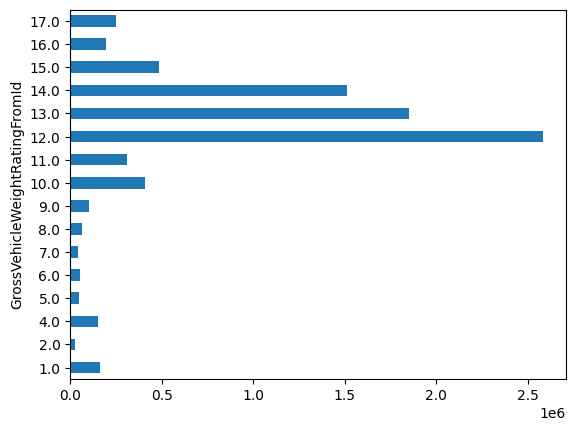

In [24]:
nydmvVinDecodeDf.groupby("GrossVehicleWeightRatingFromId").size().plot.barh()

In [25]:
comb = nydmvVinDecodeDf.fillna(0).groupby(["ModelID","ModelYear"]+list(safetyColMap.values())).size().values

In [26]:
len(nydmvVinDecodeDf[["ModelID","ModelYear"]].drop_duplicates()), len(comb)

(35457, 37923)